This notebook explores, on a small scale, the Sherrington-Kirkpatrick model in a qualitative fashion. This is a model that shares many qualitative properties with the systems I have worked with for my Ph.D. research. 

This system consists of a bunch of different particles $\sigma_i$ that can have some binary property, i.e. each particle can be in a $\sigma_i=+1$ or $\sigma_i=-1$ state. These can be electrons in the molecules of a solid, where the binary property is a classical approximation of spin $\frac{1}{2}$, neurons, where the binary property is acticated or not activated, amoung other systems.

Generally, in physics, we define systems through some energy function. Usually, the total energy of the system is will not change, but we're going to focus on "zero temperature physics", where any energy in excess of the minimum possible energy will be lost to heating the outside world. This turns out to be a pretty good way of figuring out how the real 

The model itself is defined by the Hamiltonian $H(\sigma)=-\sum_{i,j}^n J_{ij} \sigma_i \sigma_j$, where $\sigma_i$ can take the values -1 or 1. For a given configuration of the $n$ $\sigma_i$'s, $\sigma$, we term $H(\sigma)$ the "energy" of the system.  Generally, at low temperatures, the combinations of the $\sigma_i$'s that we'll actually see are the ones that minimize the Hamiltonian $H$.

$J_{ij}$ is a $n \times n$ matrix that takes on random values - below we'll draw it from a normal distribution. We're going to look at some pretty small systems, with only $n=20$ or so particles, but real systems will be on the order of $n=10^{25}$ or so. However, we'll be able to see some of the qualitative properties from these small sample sizes.

Because we're looking at a really small system, it will be reasonable to look at every single possible configuration of the $\sigma_i$'s.

In [1]:
addprocs(CPU_CORES)

4-element Array{Any,1}:
 2
 3
 4
 5

In [2]:

@everywhere const n=20
@everywhere const sdJ=1/sqrt(n) #variance of $H \propto n^2$, this makes low energy states/ variance of $H \propto n$
@everywhere const meanJ=0


In [3]:
trials=500

500

We'll keep track of our $\sigma$ states by looking at the integer index in binary. 1 -> 1, 0 ->-1

In [4]:
@everywhere function bitarray(int::Int)  
    2*digits(int,2,n)-1
end

In [5]:
@everywhere function energy(index, J)
    c=bitarray(index)
    -sum(J.*reshape(kron(c,c),(n,n)))
end

The distance function defines a distance between states, given by how 
many flips (i.e. changing a single $\sigma$ from +1 to -1 or vice versa) it takes to get from one state to the other. Since a given state and that state with 
all $\sigma$'s flipped are equivalent, we have to check the 
distance between both equivalent states. Since we indexed our states by the
binary representation, the xor operator can do the work of finding the distance
for us.

In [6]:

@everywhere function distance(a::Int,b::Int)     
    min(sum(digits(a$b,2,n)),sum(digits((2^(n+1)-1-a)$b,2,n)))
end

We're just going to focus on the two states with the lowest $H$, and look at the difference in $H$ between them (the "energy gap") and the number of flips (the "distance") between them.

In [7]:
@everywhere function energydifferance(energies)   
    lowenergy=findmin(energies)
    energies[lowenergy[2]]=NaN
    secondlow=findmin(energies)
    [lowenergy[1]-secondlow[1],distance(lowenergy[2]-1,secondlow[2]-1)]
end
@everywhere function energyinstance(J)
    energydifferance([energy(i,J) for i=0:2^(n-1)-1])
end

In [8]:
gapdistance=@parallel (vcat) for i=1:trials
    transpose(energyinstance(randn(n,n)*sdJ+meanJ))
end


500x2 Array{Float64,2}:
 -1.52002     1.0
 -0.439904    1.0
 -0.79991     2.0
 -0.00615762  2.0
 -0.867372    1.0
 -0.145954    1.0
 -0.485871    1.0
 -0.564654    2.0
 -0.526598    8.0
 -0.0871254   1.0
 -0.906559    5.0
 -0.572339    7.0
 -0.466105    1.0
  ⋮              
 -0.132453    1.0
 -0.39623     2.0
 -0.230123    1.0
 -0.304575    1.0
 -0.103777    1.0
 -0.29768     4.0
 -0.0831471   2.0
 -0.134281    3.0
 -0.14472     6.0
 -0.989995    8.0
 -0.502245    3.0
 -1.08764     1.0

In [9]:
@everywhere using KernelDensity

In [10]:
densityKDE=kde(gapdistance)
densitypnts=@parallel (vcat) for i=1:trials
    pdf(densityKDE, gapdistance[i,1],gapdistance[i,2])
end

500-element Array{Float64,1}:
 0.0157673
 0.401037 
 0.0888974
 0.245511 
 0.155062 
 0.525558 
 0.359893 
 0.148037 
 0.0262893
 0.470595 
 0.0111362
 0.0253694
 0.378285 
 ⋮        
 0.519523 
 0.185321 
 0.504065 
 0.469111 
 0.493869 
 0.0802089
 0.317738 
 0.154841 
 0.0674836
 0.0084889
 0.0763751
 0.0676384

In [11]:
rmprocs(workers())

:ok

In [12]:
using PyPlot

INFO: Loading help data...


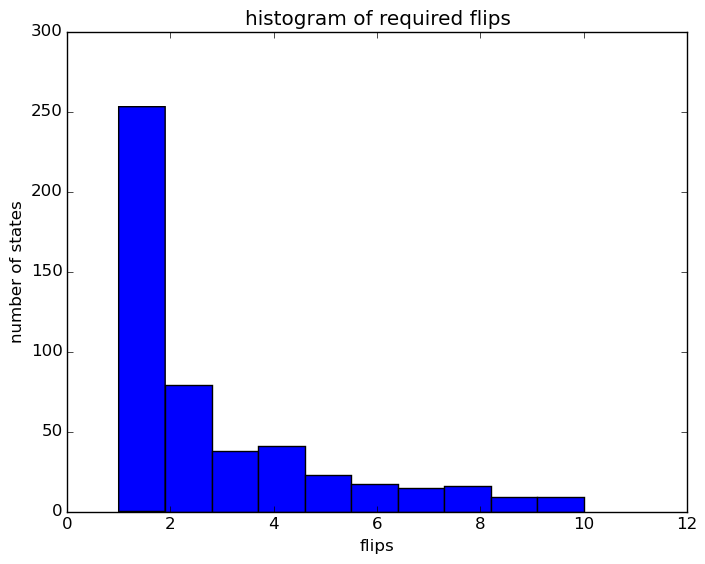

In [13]:
PyPlot.plt.hist(gapdistance[:,2],ceil(n/2))
title("histogram of required flips ")
ylabel("number of states")
xlabel("flips")
show()

We can see that, while about 50% of the two neighboring lowest states are just one flip away from each other, quite a few of them are a lot farther, and some even take the maximum possible number of flips.

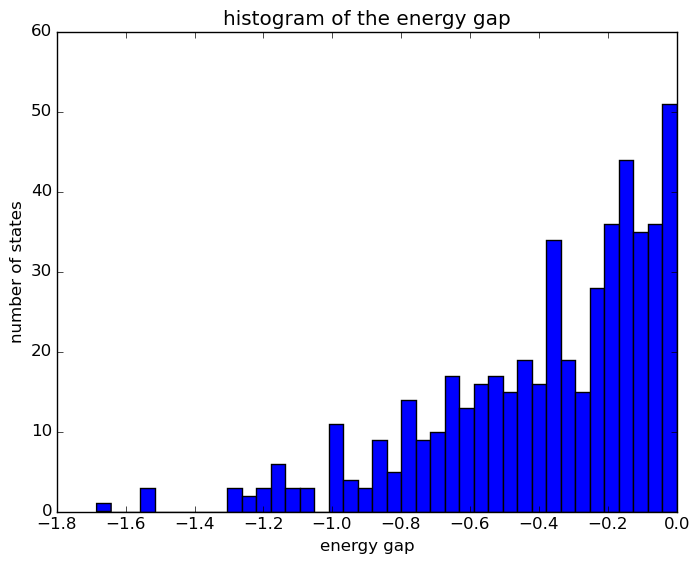

In [14]:
PyPlot.plt.hist(gapdistance[:,1],40)
title("histogram of the energy gap ")
ylabel("number of states")
xlabel("energy gap")
show()

The distribution of the energy gap is clustered around zero, and as we see below, some of the states are those that are very far from each other.  Even for this very small sample, we see that there are low energy states that are at nearly the same energy, yet it will take a significant change in the system configuration to lower that energy the small amount.

For most physical systems, finding the low temperature behavior comes down to finding the global energy minimum. In this model, however, we see evidence of what is called "glassy" behavior: the system has many states clustered around a low energy. However, these states may be very distinct from each other, and become physically relevant.  Thus, the local minima are equally important to the global one. This generally causes what is called "Hysteresis", where the current state of the system is dependent on the past states.

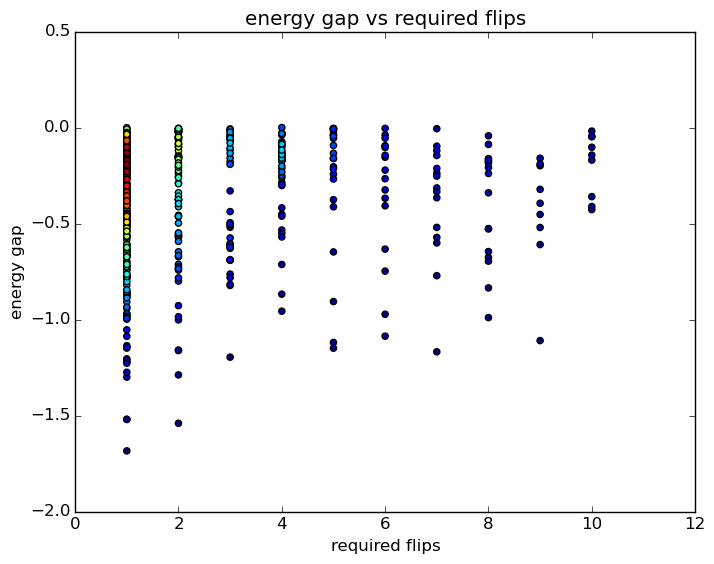

In [15]:
scatter(gapdistance[:,2],gapdistance[:,1],c=densitypnts)
title("energy gap vs required flips")
xlabel("required flips")
ylabel("energy gap")
show()